In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sklearn as sk
import sklearn.gaussian_process as gp
from datetime import timedelta as dt

In [99]:
df = pd.read_csv('sotonmet.txt')

Defining variables by indexing columns from DataFrame

In [100]:
t = df['Reading Date and Time (ISO)'] #time
y = df['Tide height (m)']   #Tide height reading
y_true = df['True tide height (m)'] #Ground truth tide heights

Plot of Tide Height (m) against DateTime (ISO)

In [101]:
# Convert t's elements from string to DateTime objects
t=t.apply(datetime.datetime.fromisoformat)

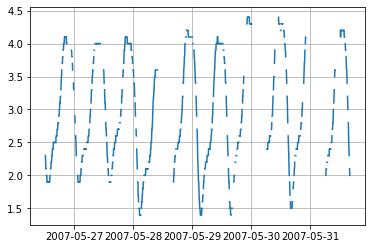

In [102]:
plt.plot(t,y)
plt.grid()

Tide Height displays periodicity as can be seen in plot above.

Start with Exponentiated Quadratic (no white kernel)

In [103]:
df['Reading Date and Time (ISO)']=df['Reading Date and Time (ISO)'].apply(datetime.datetime.fromisoformat)

In [104]:
df['Time'] = np.nan
df['Time'] = (df['Reading Date and Time (ISO)']-df['Reading Date and Time (ISO)'].iloc[0])
df['Time']=df['Time'].dt.total_seconds()

In [105]:
df_training=df.drop(df[df['Tide height (m)'].isnull()].index)
df_missing = df[df['Tide height (m)'].isnull()]

In [106]:
X = df_training[['Tide height (m)','Time']].to_numpy()
X_missing = df_missing['Time'].to_numpy()
X_GT=df_missing['True tide height (m)'].to_numpy()

In [107]:
x_training=X[:,0].reshape(-1,1)
t_training = X[:,1].reshape(-1,1)
X_GT = X_GT.reshape(-1,1)

In [108]:
t2=X_missing.reshape(-1,1)


In [40]:
kernel1=gp.kernels.RBF(length_scale=0.01,length_scale_bounds=(1e-7,1e8))

In [41]:
gpr=gp.GaussianProcessRegressor(normalize_y=False,kernel=kernel1,n_restarts_optimizer=20)
gpr.fit(t_training,x_training)

GaussianProcessRegressor(kernel=RBF(length_scale=0.01), n_restarts_optimizer=20)

In [42]:
answer=gpr.predict(t2)

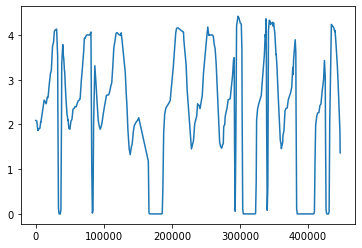

In [43]:
plt.plot(t2,answer)


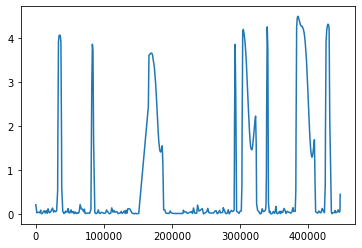

In [44]:
plt.plot(t2,abs(answer-X_GT))

In [45]:
d1={}
for A,B in zip(np.reshape(t2,-1),np.reshape(answer,-1)):
    d1[A]=B

d2={}
for A,B in zip(np.reshape(t2,-1),np.reshape(X_GT,-1)):
    d2[A]=B

In [46]:
df_index = df.set_index('Time')
df_predicted=df_index['Tide height (m)'].fillna(d1)
df_actual=df_index['Tide height (m)'].fillna(d2)

Text(0, 0.5, 'Tide Height (m)')

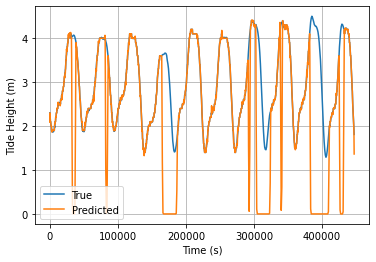

In [51]:
plt.plot(df_actual.index,df_actual,label='True')
plt.plot(df_predicted.index,df_predicted,label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Tide Height (m)')

In [52]:
rms_error = np.sqrt(np.average(np.square(answer-X_GT)))
print(rms_error)

1.7484734844496133


Exponentiated Quadratic with White Kernel

In [58]:
kernel2=gp.kernels.RBF(length_scale=0.01,length_scale_bounds=(1e-7,1e8)) + gp.kernels.WhiteKernel()

gpr=gp.GaussianProcessRegressor(normalize_y=False,kernel=kernel2,n_restarts_optimizer=20)
gpr.fit(t_training,x_training)
answer=gpr.predict(t2)

In [59]:
d1={}
for A,B in zip(np.reshape(t2,-1),np.reshape(answer,-1)):
    d1[A]=B

d2={}
for A,B in zip(np.reshape(t2,-1),np.reshape(X_GT,-1)):
    d2[A]=B

df_index = df.set_index('Time')
df_predicted=df_index['Tide height (m)'].fillna(d1)
df_actual=df_index['Tide height (m)'].fillna(d2)

Text(0, 0.5, 'Tide Height (m)')

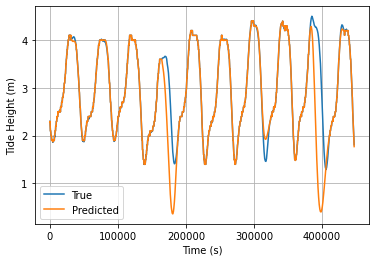

In [60]:
plt.plot(df_actual.index,df_actual,label='True')
plt.plot(df_predicted.index,df_predicted,label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Tide Height (m)')

In [62]:
rms_error = np.sqrt(np.average(np.square(answer-X_GT)))
print(rms_error)

0.6670949086663167


In [63]:
gpr.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel__k1': RBF(length_scale=0.01),
 'kernel__k2': WhiteKernel(noise_level=1),
 'kernel__k1__length_scale': 0.01,
 'kernel__k1__length_scale_bounds': (1e-07, 100000000.0),
 'kernel__k2__noise_level': 1.0,
 'kernel__k2__noise_level_bounds': (1e-05, 100000.0),
 'kernel': RBF(length_scale=0.01) + WhiteKernel(noise_level=1),
 'n_restarts_optimizer': 20,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

Since data displays periodicity, try Exp-Sine-Squared Kernel (periodic kernel) with no White Kernel

In [109]:
kernel3=gp.kernels.ExpSineSquared() + gp.kernels.WhiteKernel()

In [110]:
gpr=gp.GaussianProcessRegressor(normalize_y=False,kernel=kernel3,n_restarts_optimizer=10)
gpr.fit(t_training,x_training)

/Users/terencetan/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [111]:
answer=gpr.predict(t2)

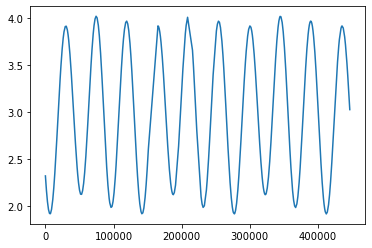

In [112]:
plt.plot(t2,answer)


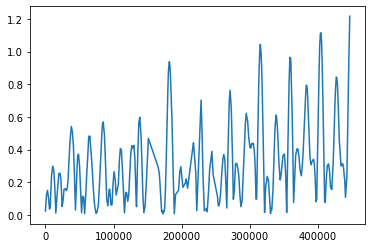

In [113]:
plt.plot(t2,abs(answer-X_GT))

In [114]:
d1={}
for A,B in zip(np.reshape(t2,-1),np.reshape(answer,-1)):
    d1[A]=B

d2={}
for A,B in zip(np.reshape(t2,-1),np.reshape(X_GT,-1)):
    d2[A]=B

In [115]:
df_index = df.set_index('Time')
df_predicted=df_index['Tide height (m)'].fillna(d1)
df_actual=df_index['Tide height (m)'].fillna(d2)

Text(0, 0.5, 'Tide Height (m)')

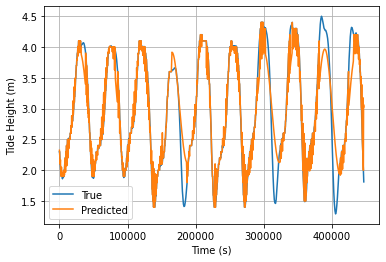

In [116]:
plt.plot(df_actual.index,df_actual,label='True')
plt.plot(df_predicted.index,df_predicted,label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Tide Height (m)')

In [118]:
rms_error = np.sqrt(np.average(np.square(answer-X_GT)))
print(rms_error)

0.4332071684623606


Try ExpSineSquared with White Kernel

In [81]:
kernel4=gp.kernels.ExpSineSquared() + gp.kernels.WhiteKernel()

gpr=gp.GaussianProcessRegressor(normalize_y=False,kernel=kernel4,n_restarts_optimizer=10)
gpr.fit(t_training,x_training)
answer=gpr.predict(t2)


/Users/terencetan/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [82]:
d1={}
for A,B in zip(np.reshape(t2,-1),np.reshape(answer,-1)):
    d1[A]=B

d2={}
for A,B in zip(np.reshape(t2,-1),np.reshape(X_GT,-1)):
    d2[A]=B


df_index = df.set_index('Time')
df_predicted=df_index['Tide height (m)'].fillna(d1)
df_actual=df_index['Tide height (m)'].fillna(d2)

Text(0, 0.5, 'Tide Height (m)')

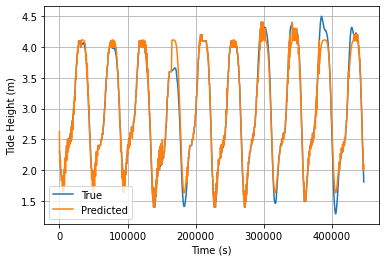

In [83]:
plt.plot(df_actual.index,df_actual,label='True')
plt.plot(df_predicted.index,df_predicted,label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Tide Height (m)')

In [84]:
# Root Mean Square Error
rms_error = np.sqrt(np.average(np.square(answer-X_GT)))
print(rms_error)

0.19214527078599847
